In [5]:
"""Use Nick's PPO trained policy to perform inference on whether there is a pedestrian or not"""

import argparse
from datetime import datetime
import gym
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import PyQt5

import ray
try:
    from ray.rllib.agents.agent import get_agent_class
except ImportError:
    from ray.rllib.agents.registry import get_agent_class
from ray.tune.registry import register_env

# from flow.algorithms.maddpg.maddpg import DEFAULT_CONFIG as MADDPG_DEFAULT_CONFIG, MADDPGTrainer


from flow.core.util import emission_to_csv
from flow.utils.registry import make_create_env
from flow.utils.rllib import get_flow_params
from flow.utils.rllib import get_rllib_config
from flow.utils.rllib import get_rllib_pkl

from examples.rllib.multiagent_exps.test_predictor.pedestrian_policy_1 import create_env, create_agent
from examples.rllib.multiagent_exps.bayesian_0_no_grid_env import make_flow_params as bayesian_1_flow_params

EXAMPLE_USAGE = """
example usage:
    python ./visualizer_rllib.py /ray_results/experiment_dir/result_dir 1
Here the arguments are:
1 - the path to the simulation results
2 - the number of the checkpoint
"""

In [6]:
import tensorflow as tf
import ray
import gym

In [7]:
ray.__version__

'0.8.0'

# The Math

$$ p(c|a) = \frac{f(a|c) p(c)}{M}, M = \sum_{e \in every} f(a | e) p(e), c \text{ is some joint ped combination}$$

#### Code flow

e denotes an element within the 'every' set, where 'every' = the set of all possible pedestrian location combinations observable by a vehicle

o denotes an element with the 'other' set, where 'other' = the set of all possible pedestrian location combinations observable by a vehicle, where $o_1 = 1$ or some other specific location has a fixed value.
 
0. Fill up $p(e)$ with $\frac{1}{3^4}$

1. Fill up $f(a|e)$

2. Compute $M = \sum_{e \in every} f(a|e) p(e)$

3. Compute $p(e|a) = \frac{f(a|e) p(e)}{M}$ 

4. Update $p(e) = p(e|a)$

5. Compute $p(o_i = b_i | a) = \sum_{o \in other} p(o|a)$

6. Store $p(o_i = b_i)$

In [15]:
def run_env(env, agent, config, flow_params):
    """Run the simulation and control the rl car using the trained policy. 
    
    observation[4:10] = ped_param
    
    The six binary grids are at indices 4 to 9 inclusive
    """
    # set up relevant policy and env
    if config.get('multiagent', {}).get('policies', None):
        multiagent = True
        rets = {}
        # map the agent id to its policy
        policy_map_fn = config['multiagent']['policy_mapping_fn']
#         policy_map_fn = config['multiagent']['policy_mapping_fn'].func
        for key in config['multiagent']['policies'].keys():
            rets[key] = []
    else:
        multiagent = False
        rets = []

    if config['model']['use_lstm']:
        use_lstm = True
        if multiagent:
            state_init = {}
            # map the agent id to its policy
#             policy_map_fn = config['multiagent']['policy_mapping_fn'].func

            policy_map_fn = config['multiagent']['policy_mapping_fn']
            size = config['model']['lstm_cell_size']
            for key in config['multiagent']['policies'].keys():
                state_init[key] = [np.zeros(size, np.float32),
                                   np.zeros(size, np.float32)]
        else:
            state_init = [
                np.zeros(config['model']['lstm_cell_size'], np.float32),
                np.zeros(config['model']['lstm_cell_size'], np.float32)
            ]
    else:
        use_lstm = False

    env.restart_simulation(
        sim_params=flow_params['sim'], render=flow_params['sim'].render)
    
    # TODO(KL) HARD CODED ped_idx_lst - UPDATE THIS IF GET_STATE IS UPDATED
    
    ped_idx_lst = [5, 6, 7, 8]
    ped_front = ped_idx_lst[0]
    ped_back = ped_idx_lst[-1]
    
    num_locs = 4
    flag_set = ("-1", "0", "1")
    binary_observations = False
    
    joint_ped_combos_str = all_ped_combos_strs(num_locs, flag_set)
    joint_ped_combos_int_list = all_ped_combos_lsts(num_locs, flag_set)
    single_ped_combs_str = single_ped_posteriors_strs(num_locs, flag_set)
    print(f'{joint_ped_combos_str}, {joint_ped_combos_int_list} joint_ped_combos_int_list')
    print(list(zip(joint_ped_combos_str, joint_ped_combos_int_list)))
    # 0 Fill up joint priors dict p(e)
    joint_priors_fixed = {comb : [1 / (len(flag_set)**num_locs)] for comb in joint_ped_combos_str}
    joint_priors_updated = {comb : [1 / (len(flag_set)**num_locs)] for comb in joint_ped_combos_str}
    
    # 1 Fill up joint_likelihood_densities dict f(a|e)
    joint_likelihood_densities = {comb : [] for comb in joint_ped_combos_str}
    
    # 2 Compute M
    
    # 3 Compute joint_posteriors p(e|a) [including the first prior]
    joint_posteriors_fixed = {comb : [] for comb in joint_ped_combos_str}
    joint_posteriors_updated = {comb : [] for comb in joint_ped_combos_str}

    # 4 Compute single_posteriors p(e|a) by summing relevant joint posteriors
    single_posteriors_fixed = {comb : [] for comb in single_ped_combs_str}
    single_posteriors_updated = {comb : [] for comb in single_ped_combs_str}
    
    visible_pedestrian_dct = {loc : [] for loc in range(num_locs)}
    intersection_status = []

    for i in range(args.num_rollouts):
        state = env.reset()
        for _ in range(800):
            vehicles = env.unwrapped.k.vehicle
            pedestrian = env.unwrapped.k.pedestrian
            if multiagent:                
                action, logits = {}, {}
                for agent_id in state.keys():
                    if use_lstm:
                        action[agent_id], state_init[agent_id], logits = \
                            agent.compute_action(state[agent_id], state=state_init[agent_id], policy_id=policy_map_fn(agent_id))
                    else:
                        if state != {}:
                            # s_all = state the agent observes
                            s_all = state[agent_id]
                            # get ped visibility state array of length 6 from the rl car's POV
                            s_ped = s_all[ped_idx_lst]

                            # compute the actual action taken by the rl car
                            action[agent_id], _, logit_actual = agent.compute_action(state[agent_id], policy_id=policy_map_fn(agent_id), full_fetch=True)    
                            action_ = action[agent_id][0]
                            
                            # update the visible_pedestrian dict
                            for idx, val in enumerate(s_ped):
                                visible_pedestrian_dct[idx] = visible_pedestrian_dct[idx] + [val]

                            # update rl car's intersection status
                            rt = vehicles.get_route('rl_0')
                            if vehicles.get_edge('rl_0') == rt[0]:
                                intersection_status.append(-1)
                            elif vehicles.get_edge('rl_0') == rt[-1]:
                                intersection_status.append(1)
                            else:
                                intersection_status.append(0)

                            # 1 compute joint likelihood densities f(a|e) and M
                            M_updated, M_fixed = 0, 0
                            
                            for str_comb, lst_comb in zip(joint_ped_combos_str, joint_ped_combos_int_list):
                                
                                s_all_modified = np.copy(s_all) # s_all_modified = hypothetical state that an agent observes
                                s_all_modified[ped_front : ped_back + 1] = lst_comb
                                _, _, logit = agent.compute_action(s_all_modified, policy_id=policy_map_fn(agent_id), full_fetch=True)

                                mu, ln_sigma = logit['behaviour_logits']
                                sigma = np.exp(ln_sigma)

                                # 1 f(a|e)
                                joint_likelihood_density = accel_pdf(mu, sigma, action_)
                                joint_likelihood_densities[str_comb] = joint_likelihood_densities[str_comb] + [joint_likelihood_density]
                                
                                # 2 M
                                # Get the updated and fixed priors
                                updated_prior = joint_priors_updated[str_comb][-1]
                                fixed_prior = joint_priors_fixed[str_comb][-1]
                                
                                M_updated += joint_likelihood_density * updated_prior
                                M_fixed += joint_likelihood_density * fixed_prior

                            # 3 Compute p(e|a) joint posterior masses
                            for str_comb in joint_ped_combos_str:
                                
                                joint_likelihood_density = joint_likelihood_densities[str_comb][-1]
                                updated_prior = joint_priors_updated[str_comb][-1]
                                fixed_prior = joint_priors_fixed[str_comb][-1]
                                
                                joint_posterior_updated = joint_likelihood_density * updated_prior / M_updated
                                joint_posterior_fixed = joint_likelihood_density * fixed_prior / M_fixed
                                
                                joint_posteriors_updated[str_comb] = joint_posteriors_updated[str_comb] + [joint_posterior_updated]
                                joint_posteriors_fixed[str_comb] = joint_posteriors_fixed[str_comb] + [joint_posterior_fixed]

                                # 4 Update the joint priors
                                joint_priors_updated[str_comb] = joint_priors_updated[str_comb] + [joint_posterior_updated]
                                
                            # 5 Compute single posteriors Pr(o_i = b_i | a)
                            for loc_ in range(num_locs):
                                for val_ in flag_set:

                                    single_posterior_updated = 0
                                    single_posterior_fixed = 0
    
                                    for key in ped_combos_one_loc_fixed_strs(loc_, val_):
                                        single_posterior_updated += joint_posteriors_updated[key][-1]
                                        single_posterior_fixed += joint_posteriors_fixed[key][-1]

                                    single_posterior_str = f'o_{loc_} = {val_}'
                                    
                                    single_posteriors_updated[single_posterior_str] = single_posteriors_updated[single_posterior_str] + [single_posterior_updated]
                                    single_posteriors_fixed[single_posterior_str] = single_posteriors_fixed[single_posterior_str] + [single_posterior_fixed]
                                
            else:
                action = agent.compute_action(state)
            
            state, reward, done, _ = env.step(action)

            if multiagent and done['__all__']:
                break
            if not multiagent and done:

                break    
            state, reward, done, _ = env.step(action)   

        visible_ped_lsts = [visible_pedestrian_dct[i] for i in range(num_locs)]
        legends = [f'ped at loc {i}' for i in range(num_locs)]

        for loc in range(num_locs):
            val = 1
            single_posterior_str = single_posterior_to_str(loc, val)
            a_ = single_posteriors_updated[single_posterior_str]
            b_ = single_posteriors_fixed[single_posterior_str]

            plot_2_lines(a_, b_, [f'Pr(ped in grid {loc} = {val}) using updated priors', f'Pr(ped in grid {loc} = {val}) using fixed priors'])

        fig = plt.figure(figsize=(10, 15))
        
        y0 = visible_pedestrian_dct[0]
        y1 = visible_pedestrian_dct[1]
        y2 = visible_pedestrian_dct[2]
        y3 = visible_pedestrian_dct[3]

        vis_ped_0 = plt.subplot(2, 3, 1)
        plt.plot(y0, 'o-')
        vis_ped_0.set_title('Pedestrian in loc 1')
        vis_ped_0.set_xlabel('time (s)')
        vis_ped_0.set_ylabel('in loc 1?')
        
        vis_ped_1 = plt.subplot(2, 3, 2)
        plt.plot(y1, 'o-')
        vis_ped_1.set_title('Pedestrian in loc 1')
        vis_ped_1.set_xlabel('time (s)')
        vis_ped_1.set_ylabel('in loc 1?')

        vis_ped_2 = plt.subplot(2, 3, 3)
        vis_ped_2.plot(y2, '.-')
        vis_ped_2.set_title('Pedestrian in loc 2')

        vis_ped_2.set_xlabel('time (s)')
        vis_ped_2.set_ylabel('in loc 2?')
        
        vis_ped_3 = plt.subplot(2, 3, 4)
        vis_ped_3.plot(y3, '.-')
        vis_ped_3.set_title('Pedestrian in loc 3')

        vis_ped_3.set_xlabel('time (s)')
        vis_ped_3.set_ylabel('in loc 3?')
        
        
        intersection = plt.subplot(2, 3, 5)
        intersection.plot(intersection_status)
        intersection.set_title('-1 = approaching, 0 = on intersection, 1 = past')
        intersection.set_xlabel('time (s)')
        intersection.set_ylabel('rl car location')


In [16]:
def single_posterior_to_str(loc, val):
    return f'o_{loc} = {val}'

def all_ped_combos_strs(num_locs=4, val_set=("-1", "0", "1")):
    """Return a list of all pedestrian observation combinations (in string format) for a vehicle under the 4 location scheme"""
    res = []
    lsts = all_ped_combos_lsts(num_locs, val_set)
    for lst in lsts:
        res.append(" ".join(lst))
    return res

def all_ped_combos_lsts(num_locs=4, val_set=("-1", "0", "1")):
    """Return a list of all pedestrian observation combinations (in list format) for a vehicle under the 4 location scheme"""
    res = []
    if num_locs == 0:
        return []
    if num_locs == 1:
        return [[flag] for flag in val_set]

    for comb in all_ped_combos_lsts(num_locs - 1, val_set):
        # append a flag for all possible flags
        for flag in val_set:
            appended = comb + [flag]
            res.append(appended)
            
    return res

def ped_combos_one_loc_fixed_strs(fixed_loc, fixed_val, num_locs=4, val_set=("-1", "0", "1")):
    """Return a list of all ped observation combs for a vehicle under the 4 location scheme
    SUBJECT TO fixed_loc == fix_val
    
    This is handy for summation selection in equation (4) of the derivation
    
    @Parameters
    fixed_loc: int
        location from 0, 1, 2, 3
    fixed_val: int
        location from -1, 0, 1
    """    
    res = []
    lsts = ped_combos_one_loc_fixed_lsts(fixed_loc, fixed_val, num_locs, val_set)
    for lst in lsts:
        res.append(" ".join(lst))
    return res

def ped_combos_one_loc_fixed_lsts(fixed_loc, fixed_val, num_locs=4, val_set=("-1", "0", "1")):
    """Return a list of all ped observation combs for a vehicle under the 4 location scheme
    SUBJECT TO fixed_loc == fix_val
    
    This is handy for summation selection in equation (4) of the derivation
    
    @Parameters
    fixed_loc: int
        location from 0, 1, 2, 3
    fixed_val: int
        location from -1, 0, 1
    """
    fixed_val = str(fixed_val)
    assert fixed_loc < num_locs and (fixed_val in val_set or str(fixed_val) in val_set)
    
    res = []
    for comb in all_ped_combos_lsts(num_locs - 1, val_set):
        # insert fixed val at correct position
        left = comb[:fixed_loc]
        right = comb[fixed_loc:]
        res.append(left + [fixed_val] + right)
    
    return res

def single_cond_prob_to_str(grid_idx, val, num_indices = 6):
    """Generate the string representing the probability:
    
    Pr(o_i = val)
    
    ex:
    For Pr(o_2 = 1), we'd have the string '21'
    NB we're 1-indexing here
    """
    assert grid_idx >= 1 and grid_idx <= num_indices
    return str(grid_idx) + str(val)

# better name for this? 
def ped_combos_for_single_cond_prob(grid_idx, val, output_len=6):
    """Helper function for computing a 'single' conditional probability e.g. p(o_3 = 1 | action)
    Returns a list of pedestrian combinations to sum over to get the single conditional probability.
    
    Params
    ------
    grid_idx: int from 1 to 6 representing the grid cell we're considering
    val: 0 or 1: 0 means no ped in the grid; 1 means ped in the grid
    
    3:0 means we want p(o_3 = 0 | a)
    Therefore, we can get the list of all possible length 5 bitstrings, and stitch '0' in the correct place.
    
    
    Returns
    -------
    list of bit strings of length 6
    """
    
    assert grid_idx >= 1 and grid_idx <= output_len
    res = []
    res_lst = make_permutations(output_len - 1, 2)
    
    for perm in res_lst:
        res.append(str(perm[:grid_idx - 1:] + str(val) + perm[grid_idx - 1:]))
        
    return res

def initial_prior_probs(num_digits=4, vals_per_dig=2):
    """Returns a dict with values of all permutations of bitstrings of length num_digits. 
    Each digit can take a value from 0 to (vals_per_dig - 1)"""
    uniform_prob = 1 / (vals_per_dig ** num_digits)
    res = make_dct_of_lsts(num_digits, vals_per_dig)
    for key in res.keys():
        res[key] = res[key] + [uniform_prob]
    return res

def make_dct_of_lsts(num_digits=4, vals_per_dig=2):
    """Return a dict with keys of bitstrings and values as empty lists. 
    Hardcoded for binary vals per var."""
    res = {}
    lst_of_bitstrings = make_permutations(num_digits, vals_per_dig)
        
    return {str_ : [] for str_ in lst_of_bitstrings}

def make_permutations(num_digits, vals_per_dig=2):
    """Make all permutations for a bit string of length num_digits
    and vals_per_dig values per digit. Hardcoded for work for binary vals per var"""
    if num_digits == 1:
        return [str(i) for i in range(vals_per_dig)]
    else:
        small_perms = make_permutations(num_digits - 1, vals_per_dig)
        # hardcoded for work for binary vals per var
        return ['0' + bit_str for bit_str in small_perms] + ['1' + bit_str for bit_str in small_perms]
    
def single_ped_posteriors_strs(num_variables=4, val_set=("-1", "0", "1")):
    """
    @Params
    num_variables = number of ped locations
    
    @Returns
    list of strings. Strings have the format: 'o_{i}={val}', where val is in val_set
    """
    res = []
    for i in range(num_variables):
        for flag in val_set:
            res.append(f'o_{i} = {flag}')
    return res

## Helper function testing suite

In [17]:
def pr_ped_given_action(action, mu_ped, s_ped, mu_no_ped, s_no_ped, prior, fixed_prior=True):
    """
    @Params
    mu_ped, s_ped: mean, sd pair from the policy receiving an input state where there is a visible pedestrian 
    mu_no_ped, s_no_ped: mean, sd pair from the policy receiving an input state where there is no visible pedestrian 

    action: the vehicle's acceleration as dictated by the policy
    prior: Pr(ped)
    fixed_prior: Boolean telling us whether to 'update' the prior Pr(ped) using Pr(ped | action) or not

    @Returns
    
    probs, a dict containing:
    1. Pr(action | ped)
    2. Pr(action | no_ped)
    3. Pr(ped | action)
    4. Pr(no_ped | action)
    5. Pr(ped) for the next computation of Pr(ped|action)
    
    3, 4, 5 are calculated subject to the fixed_prior parameter
    """
    probs = {}
    
    # Compute 1, 2: Pr(action | ped), Pr(action | no_ped)
    unnormed_pr_action_given_ped = accel_pdf(mu_ped, s_ped, action)
    unnormed_pr_action_given_no_ped = accel_pdf(mu_no_ped, s_no_ped, action)
    
    pr_a_given_ped = unnormed_pr_action_given_ped / (unnormed_pr_action_given_ped + unnormed_pr_action_given_no_ped)
    pr_a_given_no_ped = 1 - pr_a_given_ped
    
    probs["pr_a_given_ped"] = pr_a_given_ped
    probs["pr_a_given_no_ped"] = pr_a_given_no_ped
    
    # Compute 3, 4: Pr(ped | action), Pr(no_ped | action)
    # Apply Bayes' rule
    pr_ped_given_action = (pr_a_given_ped * prior) / ((pr_a_given_ped * prior)  + (pr_a_given_no_ped * (1 - prior)))
    pr_no_ped_given_action = (pr_a_given_no_ped * (1 - prior)) / ((pr_a_given_ped * prior)  + (pr_a_given_no_ped * (1 - prior)))
    probs["pr_ped_given_action"] = pr_ped_given_action
    probs["pr_no_ped_given_action"] = pr_no_ped_given_action
                    
    if fixed_prior:
        probs["prior"] = prior
    else:
        probs["prior"] = probs["pr_ped_given_action"]
    return probs
    

def accel_pdf(mu, sigma, actual):
    """Return pdf evaluated at actual acceleration"""
    coeff = 1 / np.sqrt(2 * np.pi * (sigma**2))
    exp = -0.5 * ((actual - mu) / sigma)**2
    return coeff * np.exp(exp)

def run_transfer(args):
    # run transfer on the bayesian 1 env first
    bayesian_0_params = bayesian_1_flow_params(args, pedestrians=True, render=True)
#     import ipdb; ipdb.set_trace()
    env, env_name = create_env(args, bayesian_0_params)
    agent, config = create_agent(args, flow_params=bayesian_0_params)
    run_env(env, agent, config, bayesian_0_params)

def plot_2_lines(y1, y2, legend, viewable_ped=False):
    x = np.arange(len(y1))
    plt.plot(x, y1)
    plt.plot(x, y2)
    if viewable_ped:
        plt.plot(x, viewable_ped)
    plt.legend(legend, bbox_to_anchor=(0.5, 1.05), loc=3, borderaxespad=0.)
   
    plt.draw()
    plt.pause(0.001)
    
def plot_lines(y_val_lsts, legends):
    assert len(y_val_lsts) == len(legends)
    x = np.arange(len(y_val_lsts[0]))
    for y_vals in y_val_lsts:
        plt.plot(x, y_vals)
    plt.legend(legends, bbox_to_anchor=(0.5, 1.05), loc=3, borderaxespad=0.)
    plt.draw()
    plt.pause(0.001)

In [18]:
def create_parser():
    """Create the parser to capture CLI arguments."""
    parser = argparse.ArgumentParser(
        formatter_class=argparse.RawDescriptionHelpFormatter,
        description='[Flow] Evaluates a reinforcement learning agent '
                    'given a checkpoint.',
        epilog=EXAMPLE_USAGE)

    # required input parameters
    parser.add_argument(
        'result_dir', type=str, help='Directory containing results')
    parser.add_argument('checkpoint_num', type=str, help='Checkpoint number.')

    # optional input parameters
    parser.add_argument(
        '--run',
        type=str,
        help='The algorithm or model to train. This may refer to '
             'the name of a built-on algorithm (e.g. RLLib\'s DQN '
             'or PPO), or a user-defined trainable function or '
             'class registered in the tune registry. '
             'Required for results trained with flow-0.2.0 and before.')
    parser.add_argument(
        '--num_rollouts',
        type=int,
        default=1,
        help='The number of rollouts to visualize.')
    parser.add_argument(
        '--gen_emission',
        action='store_true',
        help='Specifies whether to generate an emission file from the '
             'simulation')
    parser.add_argument(
        '--evaluate',
        action='store_true',
        help='Specifies whether to use the \'evaluate\' reward '
             'for the environment.')
    parser.add_argument(
        '--render_mode',
        type=str,
        default='sumo_gui',
        help='Pick the render mode. Options include sumo_web3d, '
             'rgbd and sumo_gui')
    parser.add_argument(
        '--save_render',
        action='store_true',
        help='Saves a rendered video to a file. NOTE: Overrides render_mode '
             'with pyglet rendering.')
    parser.add_argument(
        '--horizon',
        type=int,
        help='Specifies the horizon.')
    
    parser.add_argument('--grid_search', action='store_true', default=False,
                        help='If true, a grid search is run')
    parser.add_argument('--run_mode', type=str, default='local',
                        help="Experiment run mode (local | cluster)")
    parser.add_argument('--algo', type=str, default='TD3',
                        help="RL method to use (PPO, TD3, MADDPG)")
    parser.add_argument("--pedestrians",
                        help="use pedestrians, sidewalks, and crossings in the simulation",
                        action="store_true")
    
    return parser

2020-05-19 16:01:42,928	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-05-19 16:01:42,929	INFO resource_spec.py:216 -- Starting Ray with 4.44 GiB memory available for workers and up to 2.23 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


NOTE: With render mode sumo_gui, an extra instance of the SUMO GUI will display before the GUI for visualizing the result. Click the green Play arrow to continue.
(2.1)--(1.1) (1.1)--(1.2) 1 1
Error making env  Cannot re-register id: Bayesian0NoGridEnv-v0
True
NOTE: With render mode sumo_gui, an extra instance of the SUMO GUI will display before the GUI for visualizing the result. Click the green Play arrow to continue.
(2.1)--(1.1) (1.1)--(1.2) 1 1
Error making env  Cannot re-register id: Bayesian0NoGridEnv-v0
True
(2.1)--(1.1) (1.1)--(1.2) 1 1
Error making env  Cannot re-register id: Bayesian0NoGridEnv-v0
True


2020-05-19 16:01:48,818	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-19 16:01:48,863	INFO trainable.py:346 -- Restored from checkpoint: /home/thankyou-always/TODO/research/bayesian_reasoning_traffic/bayesian_inference/4pedbay0lesspen995/checkpoint_250/checkpoint-250
2020-05-19 16:01:48,864	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 250, '_timesteps_total': 2590093, '_time_total': 10453.522725105286, '_episodes_total': 5619}


['-1 -1 -1 -1', '-1 -1 -1 0', '-1 -1 -1 1', '-1 -1 0 -1', '-1 -1 0 0', '-1 -1 0 1', '-1 -1 1 -1', '-1 -1 1 0', '-1 -1 1 1', '-1 0 -1 -1', '-1 0 -1 0', '-1 0 -1 1', '-1 0 0 -1', '-1 0 0 0', '-1 0 0 1', '-1 0 1 -1', '-1 0 1 0', '-1 0 1 1', '-1 1 -1 -1', '-1 1 -1 0', '-1 1 -1 1', '-1 1 0 -1', '-1 1 0 0', '-1 1 0 1', '-1 1 1 -1', '-1 1 1 0', '-1 1 1 1', '0 -1 -1 -1', '0 -1 -1 0', '0 -1 -1 1', '0 -1 0 -1', '0 -1 0 0', '0 -1 0 1', '0 -1 1 -1', '0 -1 1 0', '0 -1 1 1', '0 0 -1 -1', '0 0 -1 0', '0 0 -1 1', '0 0 0 -1', '0 0 0 0', '0 0 0 1', '0 0 1 -1', '0 0 1 0', '0 0 1 1', '0 1 -1 -1', '0 1 -1 0', '0 1 -1 1', '0 1 0 -1', '0 1 0 0', '0 1 0 1', '0 1 1 -1', '0 1 1 0', '0 1 1 1', '1 -1 -1 -1', '1 -1 -1 0', '1 -1 -1 1', '1 -1 0 -1', '1 -1 0 0', '1 -1 0 1', '1 -1 1 -1', '1 -1 1 0', '1 -1 1 1', '1 0 -1 -1', '1 0 -1 0', '1 0 -1 1', '1 0 0 -1', '1 0 0 0', '1 0 0 1', '1 0 1 -1', '1 0 1 0', '1 0 1 1', '1 1 -1 -1', '1 1 -1 0', '1 1 -1 1', '1 1 0 -1', '1 1 0 0', '1 1 0 1', '1 1 1 -1', '1 1 1 0', '1 1 1 1'],

mu sigma is 2.2409868240356445 34.4404182434082
mu sigma is -2.235931634902954 13.459521293640137
mu sigma is -6.036633014678955 4.144421577453613
mu sigma is 0.6564211845397949 2.1599037647247314
mu sigma is -2.7075791358947754 1.284414529800415
mu sigma is -4.649662017822266 0.5169516801834106
mu sigma is -0.38596227765083313 7.868679523468018
mu sigma is -3.901139736175537 3.061661720275879
mu sigma is -5.30098819732666 0.9772988557815552
mu sigma is -1.1573824882507324 22.821855545043945
mu sigma is -4.732626914978027 6.40527868270874
mu sigma is -5.973252773284912 2.0842208862304688
mu sigma is 3.4200196266174316 8.002175331115723
mu sigma is 2.748180389404297 4.536943435668945
mu sigma is 1.2322858572006226 1.9535895586013794
mu sigma is 3.4160289764404297 32.09394073486328
mu sigma is 2.6559484004974365 18.014345169067383
mu sigma is 0.6663227081298828 5.523640155792236
mu sigma is 3.411466360092163 80.83548736572266
mu sigma is 2.3370611667633057 48.08464431762695
mu sigma is -

mu sigma is 2.262369394302368 1.0162415504455566
mu sigma is 0.31184738874435425 0.3531680107116699
mu sigma is -2.5008528232574463 0.15329350531101227
mu sigma is 2.2124392986297607 2.1265225410461426
mu sigma is -0.6867035627365112 0.6068735122680664
in distribution samples
mu sigma is -4.30346155166626 0.3057537376880646
mu sigma is 2.1957693099975586 4.656284809112549
mu sigma is -1.606857180595398 1.2164356708526611
mu sigma is -5.624379634857178 0.8433352112770081
mu sigma is 1.654425024986267 0.5208213329315186
mu sigma is -1.3616288900375366 0.2182197868824005
mu sigma is -4.679858684539795 0.16236890852451324
mu sigma is 1.1329363584518433 1.048802375793457
mu sigma is -3.424967050552368 0.4631113111972809
mu sigma is -6.012999534606934 0.376171737909317
mu sigma is 0.07203056663274765 2.8175740242004395
mu sigma is -5.165875434875488 1.4807226657867432
mu sigma is -6.9305877685546875 1.1294326782226562
mu sigma is -0.89159095287323 0.5365536212921143
mu sigma is -3.7687871456

mu sigma is 2.9000744819641113 40.695796966552734
mu sigma is 2.0469038486480713 21.69200325012207
mu sigma is 0.12882710993289948 6.474599838256836
mu sigma is 2.9422528743743896 97.8897933959961
mu sigma is 1.765913963317871 55.631160736083984
mu sigma is -0.6141259670257568 14.241037368774414
mu sigma is 2.5671699047088623 7.563570022583008
mu sigma is 1.3993849754333496 3.201176404953003
mu sigma is -0.6940971612930298 1.4070833921432495
mu sigma is 2.5796899795532227 22.050039291381836
mu sigma is 1.2481069564819336 8.76697826385498
mu sigma is -1.8652474880218506 3.203601360321045
mu sigma is 2.709282398223877 55.2967414855957
mu sigma is 0.7151429653167725 25.955780029296875
mu sigma is -3.1859731674194336 8.482516288757324
mu sigma is 1.5799003839492798 5.454107761383057
mu sigma is -0.8397455215454102 3.2005016803741455
mu sigma is -3.484611988067627 1.5929951667785645
mu sigma is 1.3814398050308228 13.445898056030273
mu sigma is -1.8311492204666138 7.031201362609863
mu sigma 

mu sigma is -5.250109672546387 0.05374901369214058
mu sigma is 0.5825392007827759 0.2933744192123413
mu sigma is -3.4138457775115967 0.09366213530302048
mu sigma is -6.36112117767334 0.10012185573577881
mu sigma is 0.35382238030433655 0.46086040139198303
mu sigma is -4.543534278869629 0.19255168735980988
mu sigma is -6.810917377471924 0.21299858391284943
mu sigma is -1.1679576635360718 0.17961838841438293
mu sigma is -4.8423380851745605 0.0753316730260849
mu sigma is -5.992983818054199 0.05085578188300133
mu sigma is -2.6049699783325195 0.2559886872768402
mu sigma is -5.831072807312012 0.10649901628494263
mu sigma is -6.467834949493408 0.09074253588914871
mu sigma is -3.5979323387145996 0.4477301836013794
mu sigma is -6.072987079620361 0.22392486035823822
mu sigma is -6.856545925140381 0.2250996083021164
mu sigma is 2.2487237453460693 1.3542518615722656
mu sigma is 0.41939088702201843 0.4895654320716858
mu sigma is -1.8465235233306885 0.15064558386802673
mu sigma is 2.602984666824341 3

mu sigma is -1.1586672067642212 1.2769776582717896
mu sigma is -4.449496269226074 0.6144048571586609
mu sigma is 0.9090956449508667 8.23912239074707
mu sigma is -2.417663097381592 3.212745428085327
mu sigma is -5.618107795715332 1.0075342655181885
mu sigma is 0.9230480194091797 15.799376487731934
mu sigma is -3.1977481842041016 6.917267322540283
mu sigma is -5.831641674041748 1.9034327268600464
mu sigma is 1.110983967781067 0.44582435488700867
mu sigma is -0.9675476551055908 0.13993573188781738
mu sigma is -3.2605507373809814 0.06504104286432266
mu sigma is 1.4989501237869263 0.6762650609016418
mu sigma is -1.3887710571289062 0.173418328166008
mu sigma is -4.3129448890686035 0.0910264402627945
mu sigma is 1.8116613626480103 1.028639316558838
mu sigma is -1.5981616973876953 0.23152786493301392
mu sigma is -4.883777618408203 0.15055549144744873
mu sigma is 0.4682256281375885 0.22370769083499908
mu sigma is -2.4480483531951904 0.06876537948846817
mu sigma is -5.533509731292725 0.060480248

mu sigma is -2.6161866188049316 0.14458012580871582
mu sigma is -3.8615825176239014 0.08928292244672775
mu sigma is 5.78411865234375 0.7982569932937622
mu sigma is 4.69331169128418 0.31955763697624207
mu sigma is 2.2277164459228516 0.09536519646644592
mu sigma is 6.356921672821045 1.706179141998291
mu sigma is 5.445838451385498 0.7830737233161926
mu sigma is 2.106604814529419 0.18345969915390015
mu sigma is 6.113147735595703 4.291496753692627
mu sigma is 4.904078960418701 2.4559929370880127
mu sigma is 1.3772807121276855 0.599492609500885
mu sigma is 5.007220268249512 0.5433706045150757
mu sigma is 3.1571905612945557 0.17163825035095215
mu sigma is -0.6374305486679077 0.06443279981613159
mu sigma is 5.816580295562744 1.2580134868621826
mu sigma is 3.6905922889709473 0.3917713761329651
in distribution samples
mu sigma is -1.6452068090438843 0.1282568722963333
mu sigma is 5.990055561065674 3.408092737197876
mu sigma is 3.2283191680908203 1.4602442979812622
mu sigma is -2.119029998779297 

mu sigma is 4.713217735290527 0.38790592551231384
mu sigma is 3.074470043182373 0.10327032208442688
mu sigma is 0.37173739075660706 0.030426759272813797
mu sigma is 5.33658504486084 0.7041687965393066
mu sigma is 3.179910659790039 0.15637364983558655
mu sigma is -0.36038732528686523 0.04017836973071098
mu sigma is 5.18625020980835 1.2318522930145264
mu sigma is 2.7514286041259766 0.2907866835594177
mu sigma is -1.1512984037399292 0.09530875831842422
mu sigma is 3.867664337158203 0.20177175104618073
mu sigma is 1.3440176248550415 0.05149507150053978
mu sigma is -2.5967140197753906 0.028055401518940926
mu sigma is 4.339097499847412 0.30805379152297974
mu sigma is 0.6867625713348389 0.06806712597608566
mu sigma is -3.1810364723205566 0.036526668816804886
mu sigma is 4.188281059265137 0.5469449758529663
mu sigma is -0.506015419960022 0.15898196399211884
mu sigma is -3.457468271255493 0.08922263979911804
mu sigma is 1.641619086265564 0.18144726753234863
mu sigma is -2.143035411834717 0.0581

mu sigma is 5.816580295562744 1.2580134868621826
mu sigma is 3.6905922889709473 0.3917713761329651
in distribution samples
mu sigma is -1.6452068090438843 0.1282568722963333
mu sigma is 5.990055561065674 3.408092737197876
mu sigma is 3.2283191680908203 1.4602442979812622
mu sigma is -2.119029998779297 0.49083632230758667
mu sigma is 3.3210089206695557 0.4658133387565613
mu sigma is -0.46316826343536377 0.22349976003170013
mu sigma is -3.5914230346679688 0.10068539530038834
mu sigma is 3.459623336791992 1.3533236980438232
mu sigma is -1.412764310836792 0.4948861002922058
mu sigma is -3.811490058898926 0.16225063800811768
mu sigma is 3.252980947494507 4.025962829589844
mu sigma is -1.257503867149353 1.2344605922698975
mu sigma is -3.46821928024292 0.34459424018859863
mu sigma is 6.100184440612793 1.5564374923706055
mu sigma is 5.364454746246338 1.2794963121414185
mu sigma is 3.6678943634033203 0.7986508011817932
mu sigma is 6.16773796081543 4.832760810852051
mu sigma is 5.63305139541626 

mu sigma is 4.713217735290527 0.38790592551231384
mu sigma is 3.074470043182373 0.10327032208442688
mu sigma is 0.37173739075660706 0.030426759272813797
mu sigma is 5.33658504486084 0.7041687965393066
mu sigma is 3.179910659790039 0.15637364983558655
mu sigma is -0.36038732528686523 0.04017836973071098
mu sigma is 5.18625020980835 1.2318522930145264
mu sigma is 2.7514286041259766 0.2907866835594177
mu sigma is -1.1512984037399292 0.09530875831842422
mu sigma is 3.867664337158203 0.20177175104618073
mu sigma is 1.3440176248550415 0.05149507150053978
mu sigma is -2.5967140197753906 0.028055401518940926
mu sigma is 4.339097499847412 0.30805379152297974
mu sigma is 0.6867625713348389 0.06806712597608566
mu sigma is -3.1810364723205566 0.036526668816804886
mu sigma is 4.188281059265137 0.5469449758529663
mu sigma is -0.506015419960022 0.15898196399211884
mu sigma is -3.457468271255493 0.08922263979911804
mu sigma is 1.641619086265564 0.18144726753234863
mu sigma is -2.143035411834717 0.0581

mu sigma is 5.990055561065674 3.408092737197876
mu sigma is 3.2283191680908203 1.4602442979812622
mu sigma is -2.119029998779297 0.49083632230758667
mu sigma is 3.3210089206695557 0.4658133387565613
mu sigma is -0.46316826343536377 0.22349976003170013
mu sigma is -3.5914230346679688 0.10068539530038834
mu sigma is 3.459623336791992 1.3533236980438232
mu sigma is -1.412764310836792 0.4948861002922058
mu sigma is -3.811490058898926 0.16225063800811768
mu sigma is 3.252980947494507 4.025962829589844
mu sigma is -1.257503867149353 1.2344605922698975
mu sigma is -3.46821928024292 0.34459424018859863
mu sigma is 6.100184440612793 1.5564374923706055
mu sigma is 5.364454746246338 1.2794963121414185
mu sigma is 3.6678943634033203 0.7986508011817932
mu sigma is 6.16773796081543 4.832760810852051
mu sigma is 5.63305139541626 4.614197731018066
mu sigma is 3.6951730251312256 2.3104982376098633
mu sigma is 5.941571235656738 12.473834991455078
mu sigma is 5.244080543518066 11.77648639678955
mu sigma 

mu sigma is 2.7514286041259766 0.2907866835594177
mu sigma is -1.1512984037399292 0.09530875831842422
mu sigma is 3.867664337158203 0.20177175104618073
mu sigma is 1.3440176248550415 0.05149507150053978
mu sigma is -2.5967140197753906 0.028055401518940926
mu sigma is 4.339097499847412 0.30805379152297974
mu sigma is 0.6867625713348389 0.06806712597608566
mu sigma is -3.1810364723205566 0.036526668816804886
mu sigma is 4.188281059265137 0.5469449758529663
mu sigma is -0.506015419960022 0.15898196399211884
mu sigma is -3.457468271255493 0.08922263979911804
mu sigma is 1.641619086265564 0.18144726753234863
mu sigma is -2.143035411834717 0.05810084193944931
mu sigma is -3.8233861923217773 0.02929920144379139
mu sigma is 1.0679256916046143 0.26376771926879883
mu sigma is -2.5348665714263916 0.0664004310965538
mu sigma is -3.7792606353759766 0.037258878350257874
mu sigma is 0.3803901672363281 0.5012419819831848
mu sigma is -2.6161866188049316 0.14458012580871582
mu sigma is -3.86158251762390

mu sigma is 4.713217735290527 0.38790592551231384
mu sigma is 3.074470043182373 0.10327032208442688
mu sigma is 0.37173739075660706 0.030426759272813797
mu sigma is 5.33658504486084 0.7041687965393066
mu sigma is 3.179910659790039 0.15637364983558655
mu sigma is -0.36038732528686523 0.04017836973071098
mu sigma is 5.18625020980835 1.2318522930145264
mu sigma is 2.7514286041259766 0.2907866835594177
mu sigma is -1.1512984037399292 0.09530875831842422
mu sigma is 3.867664337158203 0.20177175104618073
mu sigma is 1.3440176248550415 0.05149507150053978
mu sigma is -2.5967140197753906 0.028055401518940926
mu sigma is 4.339097499847412 0.30805379152297974
mu sigma is 0.6867625713348389 0.06806712597608566
mu sigma is -3.1810364723205566 0.036526668816804886
mu sigma is 4.188281059265137 0.5469449758529663
mu sigma is -0.506015419960022 0.15898196399211884
mu sigma is -3.457468271255493 0.08922263979911804
mu sigma is 1.641619086265564 0.18144726753234863
mu sigma is -2.143035411834717 0.0581

mu sigma is 1.7824780941009521 3.3176651000976562
mu sigma is -2.4356322288513184 0.9928467273712158
mu sigma is 5.036957740783691 8.913440704345703
mu sigma is 1.4002739191055298 5.981683254241943
mu sigma is -1.9720157384872437 1.52046537399292
mu sigma is 4.713217735290527 0.38790592551231384
mu sigma is 3.074470043182373 0.10327032208442688
mu sigma is 0.37173739075660706 0.030426759272813797
mu sigma is 5.33658504486084 0.7041687965393066
mu sigma is 3.179910659790039 0.15637364983558655
mu sigma is -0.36038732528686523 0.04017836973071098
mu sigma is 5.18625020980835 1.2318522930145264
mu sigma is 2.7514286041259766 0.2907866835594177
mu sigma is -1.1512984037399292 0.09530875831842422
mu sigma is 3.867664337158203 0.20177175104618073
mu sigma is 1.3440176248550415 0.05149507150053978
mu sigma is -2.5967140197753906 0.028055401518940926
mu sigma is 4.339097499847412 0.30805379152297974
mu sigma is 0.6867625713348389 0.06806712597608566
mu sigma is -3.1810364723205566 0.0365266688

mu sigma is 3.0935139656066895 1.5255768299102783
mu sigma is -2.2928266525268555 0.511824905872345
mu sigma is 3.2108683586120605 0.4726344645023346
mu sigma is -0.5296945571899414 0.22635765373706818
mu sigma is -3.6692686080932617 0.10375428199768066
mu sigma is 3.3287291526794434 1.3924411535263062
mu sigma is -1.5565012693405151 0.5119035840034485
mu sigma is -3.9701030254364014 0.1681765764951706
mu sigma is 3.140913248062134 4.11344051361084
mu sigma is -1.4545327425003052 1.2713533639907837
mu sigma is -3.643557071685791 0.3601641356945038
mu sigma is 5.985755443572998 1.6260349750518799
mu sigma is 5.229254722595215 1.3195677995681763
mu sigma is 3.511103868484497 0.8070115447044373
mu sigma is 6.0258378982543945 5.162713527679443
mu sigma is 5.462738513946533 4.853631019592285
mu sigma is 3.539267063140869 2.3769123554229736
mu sigma is 5.806715488433838 13.27249813079834
mu sigma is 5.107675075531006 12.500153541564941
mu sigma is 2.841498851776123 4.780466556549072
mu sigma

mu sigma is 2.710867166519165 0.18472979962825775
mu sigma is -0.6652640104293823 0.05129850283265114
mu sigma is 4.863536834716797 1.3840441703796387
mu sigma is 2.4463114738464355 0.3416760265827179
mu sigma is -1.3437063694000244 0.11574995517730713
mu sigma is 3.453298330307007 0.21173341572284698
mu sigma is 1.014804482460022 0.05535246431827545
mu sigma is -2.804452657699585 0.031726352870464325
mu sigma is 3.8696491718292236 0.33103302121162415
mu sigma is 0.4367441236972809 0.07816800475120544
mu sigma is -3.5271565914154053 0.04577858746051788
mu sigma is 3.8759851455688477 0.5994974970817566
mu sigma is -0.6851578950881958 0.18636485934257507
mu sigma is -3.84818172454834 0.1179584190249443
mu sigma is 1.421776533126831 0.18959029018878937
mu sigma is -2.3148837089538574 0.06453414261341095
mu sigma is -4.1097731590271 0.03347405046224594
mu sigma is 0.8307478427886963 0.2831788957118988
mu sigma is -2.923799753189087 0.07837248593568802
mu sigma is -4.159784317016602 0.04638

mu sigma is -3.8539445400238037 1.5566216707229614
mu sigma is 3.5021560192108154 21.632282257080078
mu sigma is -0.6665941476821899 12.710947036743164
mu sigma is -3.716052532196045 2.8741981983184814
mu sigma is 2.832728385925293 0.7374894618988037
mu sigma is 0.7644046545028687 0.21770799160003662
mu sigma is -1.8075753450393677 0.08335234969854355
mu sigma is 3.512988567352295 1.3986525535583496
mu sigma is 1.1570537090301514 0.3584617078304291
mu sigma is -2.4537906646728516 0.12680746614933014
mu sigma is 3.8231959342956543 2.074798345565796
mu sigma is 1.3055490255355835 0.5784941911697388
mu sigma is -2.7169437408447266 0.27693939208984375
mu sigma is 2.229644298553467 0.31618019938468933
mu sigma is -0.8873965740203857 0.10283003747463226
mu sigma is -4.490156173706055 0.06978023052215576
mu sigma is 2.3399829864501953 0.5572764873504639
mu sigma is -1.9514650106430054 0.19612948596477509
mu sigma is -5.141329288482666 0.13559399545192719
mu sigma is 2.2378804683685303 1.11645

mu sigma is 1.1779886484146118 4.209640979766846
mu sigma is 4.0333638191223145 33.348724365234375
mu sigma is 3.2337939739227295 25.32141876220703
mu sigma is 0.889134407043457 7.158044338226318
mu sigma is 4.026956558227539 4.0897746086120605
mu sigma is 2.6933774948120117 2.2223784923553467
mu sigma is -0.14392425119876862 0.7451035380363464
mu sigma is 4.051503658294678 14.093306541442871
mu sigma is 2.546372890472412 7.694737911224365
mu sigma is -1.2654473781585693 2.0674989223480225
mu sigma is 3.983015298843384 25.403057098388672
mu sigma is 2.2211380004882812 15.136358261108398
mu sigma is -2.125373125076294 4.536680698394775
mu sigma is 3.0912647247314453 3.8825721740722656
mu sigma is 0.296279639005661 1.9405038356781006
mu sigma is -3.4123449325561523 0.8026519417762756
mu sigma is 3.211808443069458 10.751472473144531
mu sigma is -0.5318673849105835 5.251917362213135
mu sigma is -4.262963771820068 1.286449909210205
mu sigma is 3.0340089797973633 18.68755531311035
mu sigma i

mu sigma is 0.17138336598873138 0.8764820694923401
mu sigma is -4.479217529296875 0.3632836937904358
mu sigma is 3.4757089614868164 7.921023368835449
mu sigma is -0.05684056878089905 3.2555346488952637
mu sigma is -4.800464153289795 1.2351553440093994
mu sigma is 1.393792986869812 0.7541833519935608
mu sigma is -2.3199150562286377 0.36341992020606995
mu sigma is -4.873356342315674 0.17100319266319275
mu sigma is 0.9614968299865723 2.6324312686920166
mu sigma is -3.7686407566070557 0.9484670758247375
mu sigma is -5.786192893981934 0.325857937335968
mu sigma is 0.6182706356048584 6.953243732452393
mu sigma is -4.11187219619751 2.1641228199005127
mu sigma is -5.779451370239258 0.7604743838310242
mu sigma is 4.158562660217285 3.949399709701538
mu sigma is 3.1944351196289062 2.753739595413208
mu sigma is 1.315914273262024 1.2344330549240112
mu sigma is 4.0202202796936035 15.174631118774414
mu sigma is 3.036590576171875 11.19095230102539
mu sigma is 1.0455667972564697 3.6509311199188232
mu s

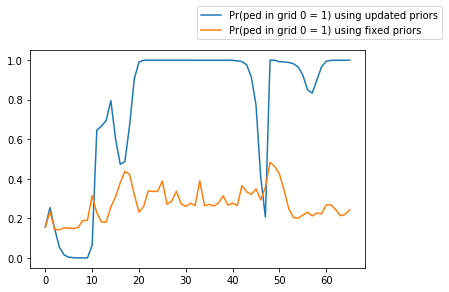

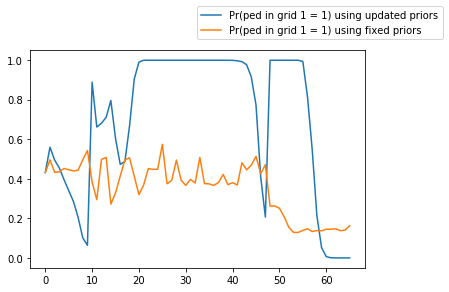

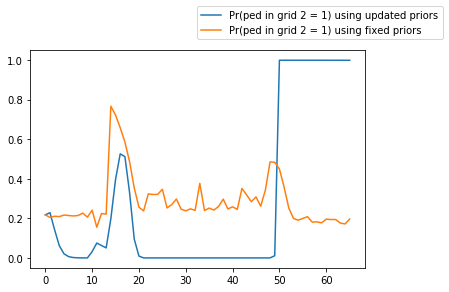

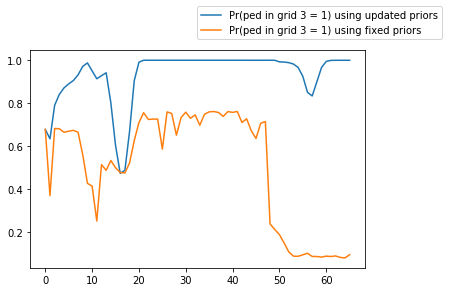

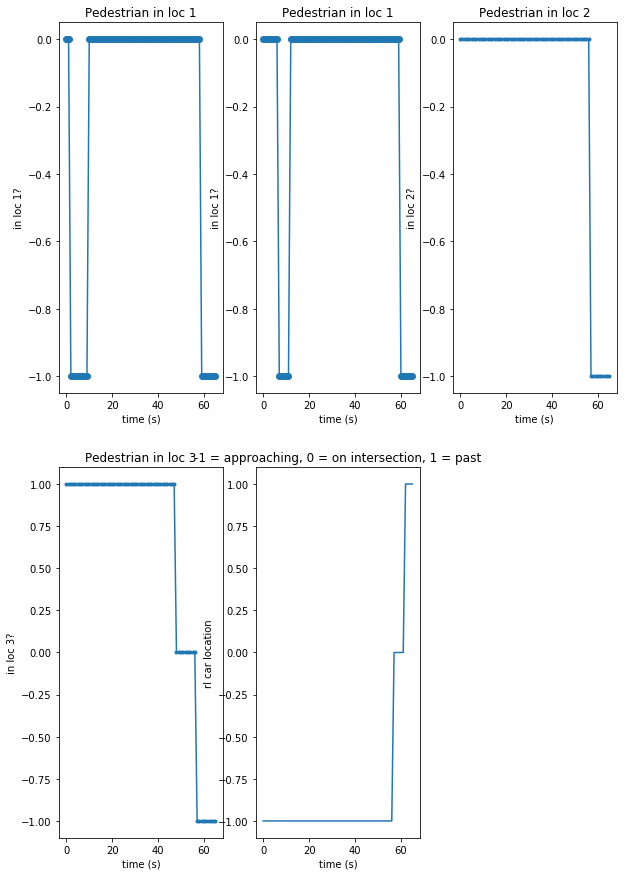

In [21]:
parser = create_parser()
args = parser.parse_args(["/home/thankyou-always/TODO/research/bayesian_reasoning_traffic/bayesian_inference/4pedbay0lesspen995", "250"])
ray.shutdown()
ray.init(num_cpus=1)
run_transfer(args)

In [ ]:
import sumo
sumo.__version__


In [ ]:
echo $PYTHONPATH

In [ ]:
b = np.array([11,22, 3, 4, 5, 6, 7])
c = [1, 2, 3]
b[c]

In [ ]:
for idx, val in enumerate(b, 1):
    print(idx, val)

In [ ]:
def f(a, b):
    return a + b

In [ ]:
str(None)

In [ ]:
fig = plt.figure()


In [ ]:
fig = plt.figure(figsize=(15, 15))

x1 = np.linspace(0.0, 1.0)
x2 = np.linspace(0.0, 1.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

vax = plt.subplot(2, 2, 1)
plt.plot(x1, y1, 'o-')
vax.set_title('A tale of 2 subplots')
vax.set_ylabel('Damped oscillation')

hax = plt.subplot(2, 2, 3)
hax.plot(x2, y2, '.-')
hax.set_title('A tale of 2 subplots')

hax.set_xlabel('time (s)')
hax.set_ylabel('Undamped')